# Titanic: Machine Learning from Disaster

In [1]:
# https://www.kaggle.com/c/titanic

In [2]:
import sklearn
import pandas as pd

In [3]:
# Загружаем данные из файлов
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Предобработка данных

In [5]:
# Заполняем пропуски в данных медианными 
# значениями факторов на обучающей выборке
train_median = train.median()
train_imp = train.fillna(train_median)
test_imp = test.fillna(train_median)

In [6]:
# Бинаризуем категориальные признаки
CATEGORY_COL = ['Sex', 'Pclass', 'Embarked']
train_dummies = pd.get_dummies(train_imp, columns=CATEGORY_COL, drop_first=True)
test_dummies = pd.get_dummies(test_imp, columns=CATEGORY_COL, drop_first=True)

In [7]:
train_dummies.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_male,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,1,0,1,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,0,0,0,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,1,0,1,0,1


In [8]:
# Удаляем лишние столбцы
DROP_COL = ['PassengerId', 'Name', 'Ticket', 'Cabin']
TARGET_COL = 'Survived'
X_train = train_dummies.drop(DROP_COL + [TARGET_COL], axis=1)
y_train = train_dummies[TARGET_COL]
X_test = test_dummies.drop(DROP_COL, axis=1)

## Предсказание моделей для стеккинга

In [11]:
import numpy as np
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

def cross_val_predict_proba(estimator, X_train, y_train):
    kfold = KFold(n_splits=4, shuffle=True, random_state=None)
    return cross_val_predict(estimator, X_train, y_train, cv=kfold, method='predict_proba')

In [14]:
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.datasets import make_classification

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

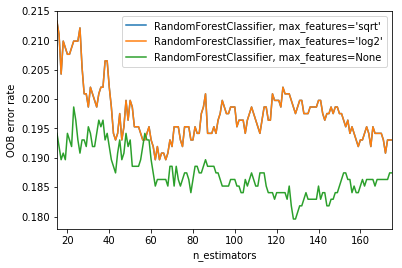

In [15]:
RANDOM_STATE = 123

# Устанавливаем аргумент warm_start=True для дообучения модели
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Создаем переменную для сохранения оценки качества на каждой итерации
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Диапазон значений числа базовых деревьев
min_estimators = 15
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        # Задаем число 
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Сохра
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Выводим зависимость качества от числа базовых моделей
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [ ]:
# TODO: подобрать гиперпараметры для ансамблей



In [ ]:
# инициализирем модели с подобранными гиперпараметрами
rf_estimator = RandomForestClassifier()
gb_estimator = GradientBoostingClassifier()

In [ ]:
# получаем предсказания вероятностей ансамблей на кросс-валидации для обучающей выборки
rf_train_pred = cross_val_predict_proba(rf_estimator, X_train, y_train)
gb_train_pred = cross_val_predict_proba(gb_estimator, X_train, y_train)

X_train_stack = np.stack([rf_train_pred[:,1], gb_train_pred[:,1]], axis=1)

In [ ]:
# получаем предсказания ансамблей для тестовой выборки
rf_test_pred = rf_estimator.fit(X_train, y_train).predict_proba(X_test)
gb_test_pred = gb_estimator.fit(X_train, y_train).predict_proba(X_test)

X_test_stack = np.stack([rf_test_pred[:,1], gb_test_pred[:,1]], axis=1)

## Объединяем предсказания ансамблей с помощью логистической регрессии

In [70]:
from sklearn.linear_model import LogisticRegression

# TODO: подобрать гиперпараметры LogisticRegression

logreg = LogisticRegression().fit(X_train_stack, y_train)
predicted = logreg.predict(X_test_stack)

## Формируем фалй для отправки

In [71]:
with open('submission.txt', 'w') as out:
    out.write('PassengerId,Survived\n')
    for passenger, y in zip(test['PassengerId'], predicted):
        out.write('%s,%s\n' % (passenger, y))